## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы.

### Библиотеки

Импорт библиотек:

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Мы имеем таблицу с данными, в которых все признаки приведены к простому виду, выделены новые полезные признаки, была произведена суммаризация раздела "О себе". Теперь мы произведем токенизацию раздела "О себе" на совокупность 3-грамм, которые мы и будем считать токенами, после чего построим эмбеддинги.

**Токенизация раздела "О себе" на 1-граммы:**

In [4]:
df = pd.read_csv('resumes_features.csv')

In [5]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [6]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
562,https://hh.ru/resume/bf3538c100015a61540039ed1...,Ведущий/главный специалист по предотвращению п...,"Москва, м. Савёловская, готов к переезду, гото...",Опыт работы 16 лет 2 месяца,- Хорошее знание бизнес-процессов оператора св...,Высшее образование (Магистр)\n2011\nМосковский...,Специализации:\nСпециалист службы безопасности...,---,Московский технический университет связи и инф...,Московский технический университет связи и инф...,...,0.001122,0.001745,-0.000003,0.000824,-0.002226,-0.00037,-0.0019,0,0.0,0.0


Для начала построим разбиение на 1-граммы (в коде также мы уберем пробелы и ненужные символы, стоп-слова, приведем слова к нормальной форме):

In [244]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

Видим, что разбиение прошло успещно:

In [245]:
df2.sample(3)

,"О себе, summarized"
1714,"[свободный, время, заниматься, спорт, саморазв..."
303,"[крупный, российский, госпредприятие, строител..."
2003,None


Теперь построим 2-граммы по 1-граммам:

In [246]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [247]:
df2.sample(3)

,"О себе, summarized",О себе 2
1363,None,None
2618,None,None
419,"[компания, работать, входить, бухгалтер, плано...","[компания работать, работать входить, входить ..."


Аналогичным образом, наконец, построим 3-граммы:

In [248]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [249]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
572,"[находиться, отпуск, санкт, петербург, хотеть,...","[находиться отпуск, отпуск санкт, санкт петерб...","[находиться отпуск санкт, отпуск санкт петербу..."
950,None,None,None
614,"[находиться, отпуск, хотеть, поделиться, свой,...","[находиться отпуск, отпуск хотеть, хотеть поде...","[находиться отпуск хотеть, отпуск хотеть подел..."


**Построение эмбеддингов**

Теперь перейдем к построению эмбеддингов. Будем использовать метод построения эмбеддингов word2vec. Определим векторное представление триграммы как среднее векторных представлений слов внутри нее.

In [250]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [251]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [252]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

Обучим модель:

In [253]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [254]:
model = Word2Vec.load("word2vec.model")

In [255]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41850, 42180)

Посмотрим, что получилось, на примере:

In [256]:
vector = model.wv['нестандартный подход решение']  # get numpy vector of a word
sims = model.wv.most_similar('нестандартный подход решение', topn=10)  # get other similar words

In [257]:
vector

array([-1.5095125e-03, -5.9101880e-03, -3.5970882e-03,  2.5117488e-03,
       -3.4773457e-03,  3.2730617e-03, -2.0137946e-03,  5.9477841e-03,
       -4.6115480e-03,  5.0545307e-03, -2.5259831e-03,  5.9516844e-03,
       -9.9157328e-03,  1.6037177e-03, -2.4902732e-03, -7.0154648e-03,
       -8.0940723e-03, -9.6410495e-04, -6.8253297e-03,  4.5497343e-03,
        9.6752737e-03, -3.3837226e-03, -8.2816910e-03, -7.1246568e-03,
       -9.2432770e-04,  2.2076059e-03, -3.2583494e-03,  8.4923198e-03,
       -8.6368909e-03, -4.6499898e-03,  2.4307012e-03,  8.9288065e-03,
        9.0017729e-03, -7.5554298e-03, -4.0973546e-03,  3.9569279e-03,
       -5.8489060e-03,  1.6115835e-03,  7.3261093e-03, -8.2826521e-03,
        1.3381350e-03, -2.5186853e-03, -5.1202672e-03,  4.6941643e-03,
        8.0492040e-03,  4.9906555e-03, -1.1957112e-03,  3.8246107e-03,
        4.9448484e-03,  1.0203001e-03,  6.4627649e-03,  3.4967838e-03,
       -1.5091031e-03, -5.1860022e-04, -7.5999619e-03,  6.7144365e-04,
      

In [258]:
sims

[('ум способность работать', 0.4243850111961365),
 ('крупный российский агентство', 0.41320833563804626),
 ('подготовка рисовый руководство', 0.3746509253978729),
 ('письменный речь быстрый', 0.37139230966567993),
 ('человек направление проектирование', 0.3670269548892975),
 ('опыт управление опыт', 0.3589009642601013),
 ('строить bi дашборд', 0.3464227020740509),
 ('эффективный проектный группа', 0.3442955017089844),
 ('футбольный болельщик готовиться', 0.34287986159324646),
 ('дважды выигрывать золото', 0.3421564996242523)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из среднего координат входящих в раздел "О себе" триграмм.

In [21]:
our_data = pd.DataFrame(df2['О себе 3'])
our_data['emb'] = 0
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)
our_data['emb'] = embs

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [22]:
our_data['flat_emb'][0]

array([-1.02169324e-04, -1.47600472e-03, -4.57081303e-04, -1.52631197e-03,
        2.28298988e-04, -6.97980053e-04, -1.07635604e-03,  2.92729703e-04,
        9.70483990e-04,  7.90853344e-04, -4.30577144e-04,  1.30937842e-03,
        2.56862608e-04,  5.32261736e-04, -1.46846622e-04, -3.71484115e-04,
       -9.41101229e-04, -8.37870175e-04,  7.56223017e-05,  3.10405681e-04,
        1.19612971e-03, -1.16170838e-03,  1.07953365e-05, -2.38714143e-04,
        2.82001100e-04, -2.46151030e-04, -4.03233600e-04, -6.50187547e-04,
       -3.18867736e-04,  1.68780761e-03,  5.04741096e-04, -1.21875817e-03,
        8.16858374e-04, -1.03954435e-03,  5.05995646e-04,  4.59402945e-04,
        3.20859865e-04, -5.79852844e-04, -1.08614244e-04, -1.51567813e-03,
       -2.50131765e-04, -7.74863060e-04, -7.21397228e-04,  2.87205941e-04,
        5.14605024e-04, -1.37540908e-03,  1.30649447e-03,  9.79384873e-04,
       -6.80062221e-04,  1.51477318e-04, -1.12231774e-03,  2.94832193e-04,
       -1.66018744e-05, -

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее $i$-х координат эмбеддингов входящих в текст эмбеддингов.

Уберем пропуски и запишем в `X` наши векторы:

In [23]:
our_data['flat_emb'].dropna()
X = list(our_data['flat_emb'].dropna())
X = np.asarray(X)
X

array([[-1.02169324e-04, -1.47600472e-03, -4.57081303e-04, ...,
        -4.65805468e-04,  7.17463321e-04,  5.34443425e-05],
       [ 7.69477512e-04, -1.33451505e-03, -1.22452620e-05, ...,
        -2.44307565e-04, -3.11685703e-03,  1.49998476e-03],
       [-2.45104369e-04,  9.64832667e-04,  2.27071811e-03, ...,
        -3.18608363e-04, -3.29043716e-04, -5.18220302e-04],
       ...,
       [ 2.54928181e-03,  2.15684413e-03,  4.07265360e-03, ...,
         2.60636723e-03, -1.64912641e-03,  4.03493177e-05],
       [-5.36227250e-04,  2.36431355e-04,  5.10334969e-03, ...,
        -7.04156049e-03,  9.01455875e-04,  6.39253389e-03],
       [-5.36227250e-04,  2.36431355e-04,  5.10334969e-03, ...,
        -7.04156049e-03,  9.01455875e-04,  6.39253389e-03]], dtype=float32)

Осталось проверить, правда ли имеющие близкое к 0 [cosine distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4) векторы похожи, а близкое к 1 — различны.

Пример ортогональных векторов:

In [24]:
df['О себе, summarized'][0]

'Уверенный пользователь ПК, Ms Word, Ms Excel, 1С, Power Point, Internet Explorer, amoCRM, Bitrix24 и офисной техники; Правовых систем Гарант и Консультант +; Знание законодательства; Работа с входящей и исходящей корреспонденцией, Этика делового общения, общения с клиентами; Навыки работы по взаимодействию с государственными органами и общественными организациями; Неоднократное участие в судебных заседаниях; Анализ данных, составление договоров, запросов, отзывов, заявлений, уведомлений.'

In [24]:
df['О себе, summarized'][1]

'В настоящее время занимаюсь благотворительной деятельностью. В свободное время занимаюсь бегом, плаванием, рисую в стиле фантази (карандаш), много путешествую, интересуюсь различиями культур и обычаями народов мира.'

In [25]:
distance.cosine(X[0], X[1])

0.9519143626093864

Действительно, мы вижим, что резбме различны.

Пример коллинеарных:

In [87]:
df['О себе, summarized'][14]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет официального места работы.'

In [88]:
df['О себе, summarized'][84]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет вакантных должностей.'

In [118]:
distance.cosine(X[14], X[84])

0.30464255809783936

Видно, что резюме похожи. 

Осталось записать эти векторы в 100 столбцов нашей таблицы:

In [30]:
for col in list(pd.DataFrame(X)):
    df[str(col)] = pd.DataFrame(X)[col]

In [31]:
df.sample(2)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
572,https://hh.ru/resume/15059d4a00075b2d080039ed1...,Руководитель направления,"Санкт-Петербург, готов к переезду (Москва), го...",Опыт работы 3 года 4 месяца,Спортивные достижения: 1 разряд по горным лыжа...,Высшее образование (Магистр)\n2022\nСанкт-Пете...,"Специализации:\nФинансовый аналитик, инвестици...","Работа с компьютерными программами, программы ...",Санкт-Петербургский государственный университе...,Санкт-Петербургский государственный университе...,...,-0.004212,-0.004020,-0.000416,-0.003047,-0.002197,0.001849,0.004545,1,2.0,0.0
1188,https://hh.ru/resume/569cbc39000738c8b40039ed1...,Старший финансовый аналитик,"Москва, м. Речной вокзал, не готова к переезду...",Опыт работы 14 лет 2 месяца,Ключевые компетенции:\n- Практические знания у...,Высшее образование\n2011\nМосковский государст...,Специализации:\nФинансовый менеджер\nФинансовы...,---,Московский государственный открытый университе...,NaN,...,0.001322,0.000618,-0.001609,0.001224,-0.000831,0.000022,0.002731,1,0.0,0.0


Сохраним то, что получилось:

In [ ]:
df.to_csv('resumes_features.csv')

**Трансформация признаков**

Мы будем обучаться не на всех признаках, а только на специально отобранных. А именно:
- Кол-во образований
- Опыт нормализованный
- Топовость образования
- Справочник по интересам
- Релокация?
- Коммандировка?
- Город?
- Уровень оборазования нормализованный
- Карьерный рост
- Аналитические комбинации слов в навыках
- 100 word2vec-векторов входящих в "О себе" триграмм

Обработаем числовые признаки:

In [32]:
txts = []
for i in range(df.shape[0]):
    txt = df.loc[i, 'Опыт нормализованный']
    # print(txt)
    if re.search('[а-яА-Я]', txt):
        txt = -1
    elif txt[-1] == ';':
        txt = int(txt[:txt.find(';')])
    else:
        txt = int(txt[:txt.find(';')]) + int(txt[txt.find(';')+1:]) / 12
    txts.append(txt)
df.loc[:, 'Опыт нормализованный'] = txts

TypeError: cannot use a string pattern on a bytes-like object

Обработаем категориальные (нам подойдет именно `LabelEncoder`, так как, к примеру, высшее образование лучше среднего, наличие аналитических комбинаций лучше отсутствия, проживание в Москве предпочтительнее для компании, чем необходимость релокации в Москву):

In [800]:
categorial = ['Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']
le = LabelEncoder()
for col in categorial:
    df[col] = le.fit_transform(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(col, ":", le_name_mapping)
df

Топовость образования : {0: 0, 1: 1}
Справочник по интересам : {0: 0, 1: 1}
Релокация? : {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Коммандировка? : {0: 0, 1: 1, 2: 2, 3: 3}
Город? : {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96}
Уровень оборазования нормализованный : {0: 0, 1: 1, 2: 2, 3: 3, 4:

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
0,https://hh.ru/resume/a179dc8e00074bc7400039ed1...,Администратор салона красоты,"Москва, м. Молодежная, не готова к переезду, г...",Опыт работы 7 лет 1 месяц,"Уверенный пользователь ПК, Ms Word, Ms Excel, ...",Высшее образование\n2015\nФГБУ ВПО «Российский...,Специализации:\nАдминистратор\nЗанятость: полн...,Коммуникации с клиентами и партнерами/Работа с...,ФГБУ ВПО «Российский экономический университет...,ФГБУ ВПО «Саратовская Государственная Юридичес...,...,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081,0,0.0,0.0
1,https://hh.ru/resume/cdaf5cfe00003bcc320039ed1...,Руководитель отдела планирования и управления ...,"Москва, м. Выхино, готова к переезду, готова к...",Опыт работы 17 лет 3 месяца,"Энергична, активна, в поиске новых возможносте...",Высшее образование\n2010\nМосковский Государст...,Специализации:\nНачальник склада\nЗанятость: п...,---,Московский Государственный Университет Экономи...,NaN,...,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458,0,0.0,0.0
2,https://hh.ru/resume/fb6ac9c200027770d60039ed1...,Начальник отдела продаж,"Шахты, готова к переезду (Москва, Санкт-Петерб...",Опыт работы 18 лет 4 месяца,"опыт прямых продаж, ведение коммерческих перег...",Высшее образование\n2001\nЮжно-Российский госу...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Южно-Российский государственный университет эк...,NaN,...,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437,3,0.0,0.0
3,https://hh.ru/resume/e23c95770000b1b95f0039ed1...,"Коммерческий директор, Финансовый директор","Москва, м. Бабушкинская, готов к переезду, гот...",Опыт работы 17 лет 5 месяцев,Коммуникабелен\nУмение работать с возражениями...,Высшее образование\n2006\nБрянский государстве...,Специализации:\nКоммерческий директор (CCO)\nФ...,---,Брянский государственный технический университет,Брянский государственный технический университет,...,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754,3,0.0,0.0
4,https://hh.ru/resume/9c86655b00073d88700039ed1...,QA/auto QA/Performance QA,"Краснодар, готов к переезду (Москва, Санкт-Пет...",Опыт работы 7 лет 10 месяцев,Дисциплина - умение выполнять поставленные зад...,Среднее специальное образование\n2009\nКраснод...,Специализации:\nТестировщик\nЗанятость: стажир...,---,Краснодарский Государственный Гуманитарно Техн...,NaN,...,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,https://hh.ru/resume/b74645f3000102b1b90039ed1...,Финансовый аналитик,"Москва, м. Крылатское, не готова к переезду, н...",Опыт работы 8 лет 11 месяцев,"Уверенный пользователь ПК: MS Office (Word, Ex...",Высшее образование\n2009\nЧувашский государств...,"Специализации:\nФинансовый аналитик, инвестици...",---,Чувашский государственный университет имени И....,NaN,...,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172,0,0.0,0.0
2721,https://hh.ru/resume/0ed518390003eb7c860039ed1...,Аналитик,"Москва, м. Ховрино, не готов к переезду, готов...",Опыт работы 3 года 4 месяца,Моя потребность в постоянном улучшении себя на...,Неоконченное высшее образование\n2019\nЮжный ф...,Специализации:\nАналитик\nЗанятость: частичная...,Другое\nДеловая коммуникация\nАдминистративное...,"Южный федеральный университет, Ростов-на-Дону",NaN,...,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534,2,0.0,0.0
2722,https://hh.ru/resume/16deef470000020e170039ed1...,Finance Controller,"Москва, м. Коммунарка, не готова к переезду, г...",Опыт работы 19 лет 1 месяц,.,Высшее образование\n1999\nSaratov State Techni...,Специализации:\nФинансовый контролер\nФинансов...,---,Saratov State Technical University,NaN,...,-0.003124,0.002176,-7.177151e-04,-0.001517,0.002639,-0.001644,-0.000034,3,0.

Вот как теперь выглядит наша таблица:

In [801]:
df.loc[:, ['Кол-во образований', 'Опыт нормализованный', 'Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках'] + list(df)[36:-3]]

,Кол-во образований,Опыт нормализованный,Топовость образования,Справочник по интересам,Релокация?,Коммандировка?,Город?,Уровень оборазования нормализованный,Карьерный рост,Аналитические комбинации слов в навыках,...,90,91,92,93,94,95,96,97,98,99
0,2,7.083333,0,0,3,3,39,1,0,1,...,-0.002147,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081
1,1,17.250000,0,0,2,1,39,1,0,0,...,0.003384,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458
2,1,18.333333,0,0,2,1,91,1,0,0,...,-0.000932,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437
3,2,17.416667,0,0,0,0,39,1,1,0,...,-0.003156,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754
4,1,7.833333,0,0,0,0,32,8,1,0,...,0.001616,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,1,8.916667,0,1,5,3,39,1,1,0,...,-0.000474,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172
2721,1,3.333333,0,1,0,2,39,5,1,0,...,-0.001979,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534
2722,1,19.083333,0,0,2,3,39,1,1,0,...,0.000261,0.001383,-0.001468,-0.003124,0.002176,-7.177151e-04,-0.001517,0.002639,-0.001644,-0.000034
2723,2,12.416667,0,0,0,0,39,1,0,0,...,0.001631,0.000190,0.003474,0.000218,0.009619,5.060604e-03,-0.008917,-0.007042,0.000901,0.006393


Сохраним то, что получилось:

In [76]:
df.to_csv('resumes_features.csv')

**Разметка данных 2**

В ноутбуке `preprocessing.ipynb` было размечено ~100 резюме. Но для хорошей работы моделей нужно больше — разметим еще ~170 резюме, чтобы размечено было около 10% всех резюме в нашей выборке.

In [307]:
# count = 0

In [758]:
print('Осталось разметить:', 112 - count)

Осталось разметить: 0


In [752]:
df_sample = df.sample(1).loc[:, ['Ссылка', 'Название', 'DA', 'DS']]
print(df_sample['Ссылка'].iloc[0])
print(df_sample['Название'].iloc[0])

https://hh.ru/resume/4f56d3c80004c880180039ed1f36514c585475?query=%D1%84%D0%B8%D0%BD%D0%B0%D0%BD%D1%81%D0%BE%D0%B2%D1%8B%D0%B9+%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA&source=search&hhtmFrom=resumes_catalog
Начальник сметного отдела


In [753]:
df.loc[df_sample.index[0], ['Название', 'DA', 'DS']]

Название    Начальник сметного отдела
DA                               -1.0
DS                                NaN
Name: 156, dtype: object

In [754]:
df.loc[df_sample.index[0], 'DA'] = 0
df.loc[df_sample.index[0], 'DS'] = 0

In [755]:
df.loc[df_sample.index[0], ['Название', 'DA', 'DS']]

Название    Начальник сметного отдела
DA                                0.0
DS                                0.0
Name: 156, dtype: object

In [756]:
count += 1

In [757]:
df.to_csv('resumes_features.csv')

Посмотрим на статистику разметки:

In [793]:
pd.DataFrame(df['DA']).value_counts()[1:].sum()

383

In [795]:
pd.DataFrame(df['DA']).value_counts()[1:].sum() / pd.DataFrame(df['DA']).value_counts()[0:].sum()

0.14055045871559632

In [797]:
pd.DataFrame(df['DS']).value_counts()

DS 
0.0    376
1.0      6
2.0      1
dtype: int64

**Классификация**

Наконец, перейдем к построению скоринговой модели (решим задачу классификации):

In [2]:
df = pd.read_csv('resumes_features.csv')

In [3]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [4]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
347,https://hh.ru/resume/5b88fd1a000290bd010039ed1...,Специалист по продаже рекламы,"Москва, м. Славянский бульвар, не готов к пере...",Опыт работы 9 лет 7 месяцев,"Веду здоровый образ жизни, без вредных привыче...",Высшее образование\n2015\nЕлецкий государствен...,"Специализации:\nМенеджер по продажам, менеджер...","Управление отношениями с клиентами, деловая ко...",Елецкий государственный университет им. И.А. Б...,NaN,...,0.001167,-0.001777,0.001526,-0.001713,0.000254,0.000469,0.001859,0,0.0,0.0


Для [оценки качества](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data) по $F_1$-мере заведем специальный словарь:

In [280]:
from sklearn.metrics import f1_score

In [281]:
from sklearn.semi_supervised import SelfTrainingClassifier

In [282]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [283]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
parameters = {
    "loss":["deviance", "exponential"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    # "base_estimator__loss":["deviance", "exponential"],
    # "base_estimator__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    # "base_estimator__min_samples_split": np.linspace(0.1, 0.5, 12),
    # "base_estimator__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    # "base_estimator__max_depth":[3,5,8],
    # "base_estimator__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    # "estimator__base_estimatorn_estimators":[10],
    }

In [285]:
def validate(alg, semi_supervised=False, not_sklearn=False):
    f1_weighted_array = []
    f1_macro_array = []
    f1_micro_array = []
    good_predictions_array = []
    value_counts_df = pd.DataFrame()
    for k in range(28):
        if semi_supervised:
            X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df.loc[df['DA'] != -1, 'DA']
            
            X_2 = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y_2 = df.loc[:, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            X_train = X_2.drop(X_test.index)
            y_train = y_2.drop(y_test.index)

            X_2.drop(X_test.index, inplace=True)
            y_2.drop(y_test.index, inplace=True)
            
            if not_sklearn:
                X = np.array(X)
                y = np.array(y).astype('int32')
                X_2 = np.array(X_2)
                y_2 = np.array(y_2).astype('int32')
                X_test = np.array(X_test)
                y_test = np.array(y_test).astype('int32')

            alg.fit(X_2, y_2)
            # print(np.unique(y_2))
        else:
            X = df.loc[df['DA'] != -1].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df.loc[df['DA'] != -1, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            alg.fit(X_train, y_train)
        
        f1_weighted = f1_score(y_test, alg.predict(X_test), average='weighted')
        f1_weighted_array.append(f1_weighted)
        f1_macro = f1_score(y_test, alg.predict(X_test), average='macro')
        f1_macro_array.append(f1_macro)
        f1_micro = f1_score(y_test, alg.predict(X_test), average='micro')
        f1_micro_array.append(f1_micro)
        
        tf = pd.DataFrame(np.array(alg.predict(X_test))==np.array(y_test)).value_counts()
        good_predictions = tf[True] / (tf[True]+tf[False])
        good_predictions_array.append(good_predictions)
        
        if k != 0:
            value_counts_df += pd.DataFrame(alg.predict(X_test)).value_counts()
        else:
            value_counts_df = pd.DataFrame(alg.predict(X_test)).value_counts()
            
    value_counts_df = value_counts_df / 28
    np.min(good_predictions_array), np.max(good_predictions_array)
    return (str(value_counts_df).strip('\ndtype: float64'), 
            np.min(good_predictions_array), 
            np.mean(good_predictions_array),
            np.max(good_predictions_array),
            
            np.min(f1_micro_array), 
            np.mean(f1_micro_array),
            np.max(f1_micro_array),
            
            np.min(f1_macro_array), 
            np.mean(f1_macro_array),
            np.max(f1_macro_array),
            
            np.min(f1_weighted_array), 
            np.mean(f1_weighted_array),
            np.max(f1_weighted_array)
            )

Начнем с логистической регрессии (она [подходит](https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification-format) для мульти-классовой классификации):

In [765]:
acc = 0.
k = 25
reg = LogisticRegression(max_iter=10000)
self_training_model = GridSearchCV(
            SelfTrainingClassifier(reg), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

lr = validate(reg)

Теперь попробуем решающие деревья:

In [766]:
acc = 0.
k = 20
clf = DecisionTreeClassifier()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

dt = validate(clf)

И, наконец, kNN:

In [767]:
acc = 0.
k = 25
clf = KNeighborsClassifier()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

knn = validate(clf)

Теперь попробуем [semi-supervised](https://medium.datadriveninvestor.com/the-ultimate-advanced-guide-of-semi-supervised-learning-3f772ed20927) версию деревьев:

Для этого `np.nan` заменим на `-1`:

In [768]:
# df.loc[~df['DA'].notna(), 'DA'] = -1

In [769]:
df['DA'].value_counts()

-1.0    2342
 0.0     339
 1.0      31
 2.0      13
Name: DA, dtype: int64

In [770]:
acc = 0.
k = 25
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)
    
dt_semi = validate(self_training_model, True)

Теперь kNN:

In [771]:
acc = 0.
k = 25
clf = KNeighborsClassifier()
self_training_model = SelfTrainingClassifier(clf)

knn_semi = validate(self_training_model, True)

Теперь LR:

In [772]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfTrainingClassifier(clf)

lr_semi = validate(self_training_model, True)

Попробуем еще

In [773]:
from sklearn.semi_supervised import LabelPropagation

In [774]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelPropagation(kernel='rbf', gamma=9e-6, max_iter=100000, tol=0.0001)

lp = validate(self_training_model, True)

In [775]:
from sklearn.semi_supervised import LabelSpreading

In [776]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelSpreading()

ls = validate(self_training_model, True)

In [777]:
from semisupervised import S3VM

In [778]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = S3VM()

s3vm = validate(self_training_model, True, True)

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:1109: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs

In [779]:
from semisup_learn.frameworks.SelfLearning import SelfLearningModel
from semisup_learn.frameworks.CPLELearning import CPLELearningModel
import sklearn

In [780]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfLearningModel(clf)

st_lr_not_sklearn = validate(self_training_model, True, True)

In [781]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = SelfLearningModel(sklearn.svm.SVC(kernel="rbf", probability=True))

st_svm_not_sklearn = validate(self_training_model, True, True)

In [782]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = LabelPropagation(kernel='rbf', gamma=9e-6, max_iter=100000, tol=0.0001)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

lp_knn = validate(self_training_model, True, True)

In [783]:
def unichr(x):
    return chr(x)

In [784]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = CPLELearningModel(sklearn.svm.SVC(kernel="rbf", probability=True), predict_from_probabilities=True)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

cple_svm = validate(self_training_model, True, True)

In [785]:
acc = 0.
k = 25
clf = LogisticRegression(max_iter=10000)
self_training_model = CPLELearningModel(clf)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

cple_lr = validate(self_training_model, True, True)

In [786]:
acc = 0.
k = 25
clf = DecisionTreeClassifier()
self_training_model = CPLELearningModel(clf)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

cple_dt = validate(self_training_model, True, True)

In [787]:
acc = 0.
k = 25
clf = KNeighborsClassifier()
self_training_model = CPLELearningModel(clf)
lp_knn = LabelPropagation(kernel='knn')
self_training_model = lp_knn
accs = []

cple_knn = validate(self_training_model, True, True)

Подробнее про Label-алгоритмы: [1](https://machinelearningmastery.com/semi-supervised-learning-with-label-spreading/), [2](https://machinelearningmastery.com/semi-supervised-learning-with-label-propagation/)

Итог:

In [823]:
metrics_clf = pd.DataFrame({'LogisticRegression': lr,
             'DecisionTree': dt,
             'kNN': knn,
             'LR semi-supervised': lr_semi,
             'DT semi-supervised': dt_semi,
             'kNN semi-supervised': knn_semi,
             'LP': lp,
             'LS': ls,
             'S3VM': s3vm,
             'SelfTrained LR not-sklearn': st_lr_not_sklearn,
             'SelfTrained SVM not-sklearn': st_svm_not_sklearn,
             'CPLE SVM': cple_svm,
             'CPLE LR': cple_lr,
             'CPLE DT': cple_dt,
             'CPLE kNN': cple_knn}, index=['mean value counts',
                                                                      'min good prediction',
                                                                      'mean good prediction',
                                                                      'max good prediction',
                                                                      'min f1 micro',
                                                                      'mean f1 micro',
                                                                      'max f1 micro',
                                                                      'min f1 macro',
                                                                      'mean f1 macro',
                                                                      'max f1 macro',
                                                                      'min f1 weighted',
                                                                      'mean f1 weighted',
                                                                      'max f1 weighted'])
metrics_clf.to_csv('metrics_clf.csv')

*Замечание.* Откуда в первой строчке берется NaN? Если они там есть — значит алгоритм плохой и не всегда давал какие-то значения такого типа.

In [32]:
0 + np.nan

nan

Мы видим, что качество при переходе к частичному обучению осталось приблизительно тем же. Однако частичное обучение решает другую задачу — заполнение пропусков, и мы применим наши алгоритмы позже.

Мы видим, что наилучшее качество было у частично-обученного DT. Тогда применим его ко всем данным (хотя прочие алгоритмы работают примерно так же).

In [828]:
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[:, 'DA']

self_training_model.fit(X, y)
y_pred = self_training_model.predict(X)
#y_pred_reg=svc.predict(X)

In [829]:
pd.DataFrame(y_pred).value_counts()

0.0    2356
1.0     268
2.0     101
dtype: int64

Мы видим, что обычная логистическая регрессия справилась с задачей гораздо лучше. Тем не менее, более сложные методы и больше размеченных данных могут, возможно, дать более хороший результат.

In [831]:
df['DA, predicted'] = y_pred

Какие получились результаты:

In [832]:
svc = LogisticRegression()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[df['DS'].notna()].loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[df['DS'].notna(), 'DS']
    
X_train = X
y_train = y
svc.fit(X_train, y_train)
y_pred = svc.predict(df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [833]:
df['DS, predicted'] = y_pred

Какие получились результаты:

In [834]:
pd.DataFrame(y_pred).value_counts()

0.0    2725
dtype: int64

Плохие. Но у нас в целом было мало подходящих резюме, поэтому мы вообще не будем рассматривать data scientist'ов.

In [307]:
pd.DataFrame(y).value_counts()

DS 
0.0    271
1.0      6
2.0      1
dtype: int64

In [308]:
df.to_csv('resumes_features.csv')

*Выводы:*

1. Алгоритмы semi-supervised learning не подходят для разметки резюме в таких задачах: слишком мало не-нулей при общем маленьком количестве размеченных данных приводит к плохой работе алгоритма
2. Для решения задачи с data scientists нужно по-другому устраивать процесс сбора данных, поскольку такие резюме совсем теряются на фоне прочих, поэтому размечать их одновременно с data analysts тяжело

Все остальные задачи будем решать только для аналитиков.

**Кластеризация**

Теперь произведем сегментацию данных с помощью кластеризации и проанализируем результаты. Для начала используем PCA.

In [42]:
df = pd.read_csv('resumes_features.csv')

In [43]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [44]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
1649,https://hh.ru/resume/b3f68a5800042392800039ed1...,Руководитель отдела/заместитель руководителя,"Москва, не готов к переезду, готов к редким ко...",Опыт работы 20 лет 4 месяца,"Знание электронных каталогов автозапчастей, SA...",Высшее образование\n2002\nМосковский автомобил...,Специализации:\nДругое\nЗанятость: полная заня...,---,Московский автомобильно-дорожный государственн...,NaN,...,0.002314,0.001616,-0.000173,-0.001082,-0.001949,-0.00005,-0.002303,0,0.0,0.0


In [45]:
scaler = StandardScaler()
x = scaler.fit_transform(df.loc[:, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [46]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Посмотрим, сколько информации сохраняют первые две главные компоненты:

In [47]:
pca.explained_variance_ratio_[:2].sum()

0.5714363530266133

In [48]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
929,-0.215845,-2.176535,-0.802485
1718,-0.000082,-2.364361,-0.729375


/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

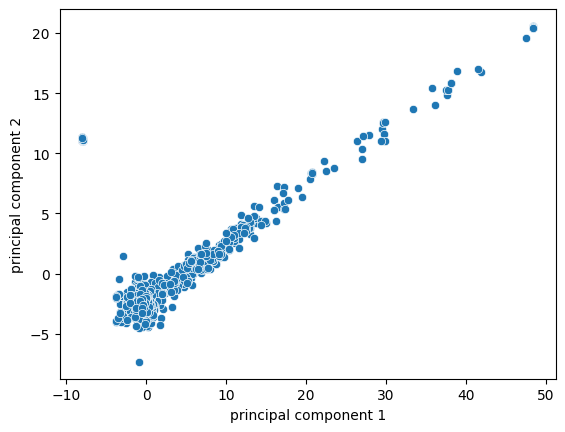

In [49]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

Теперь обучаем PCA+KMeans

Применим elbow method:

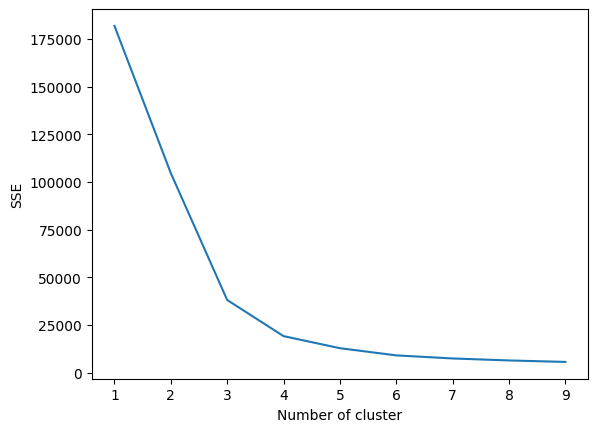

In [855]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = principal

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Выберем число кластеров 8 (по графику elbow method такое число уже неприемлемо, при этом при нем метрика лучше).

In [51]:
from sklearn import metrics

In [875]:
for k in range(2, 7):
    print(k, ':')
    kmeans = KMeans(n_clusters=k).fit(principal)
    l = kmeans.labels_
    print(metrics.silhouette_score(principal,l), metrics.silhouette_score(x,l))
    print(metrics.calinski_harabasz_score(principal,l), metrics.calinski_harabasz_score(x,l))
    print(metrics.davies_bouldin_score(principal,l), metrics.davies_bouldin_score(x,l))

2 :
0.7615937089051855 0.4203826977309822
1884.7873069655582 932.6146159930906
0.2391051771594694 0.6902102515049302
3 :
0.8244167750709599 0.45828749319714984
4568.635257371135 1208.8899543328953
0.49430831263172753 0.8144962096416467
4 :
0.8109898932665051 0.4458466486134434
5972.6453122128405 1061.2483569257047
0.49145060021349557 0.9724415436050617
5 :
0.822973620521182 0.4497352633561284
6441.335679544096 866.6519988567484
0.4772621374797488 1.0036495719274177
6 :
0.7797633717941076 0.2945463665921867
7716.5351758377155 730.7792969219136
0.5187570955720998 1.36494758612657


In [881]:
kmeans = KMeans(n_clusters=5).fit(principal)
l = kmeans.labels_

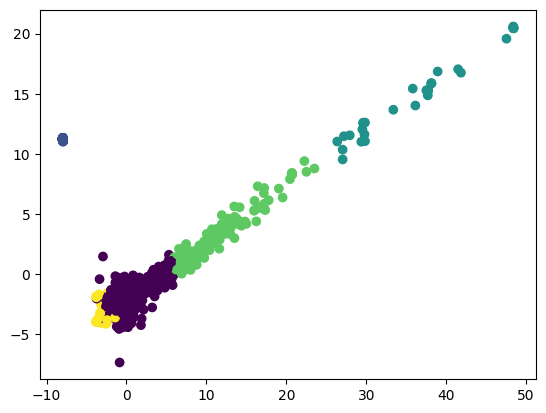

In [882]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

Оценим качество с помощью [silhouette score](https://stephenallwright.com/good-clustering-metrics/):

Теперь DBSCAN

In [81]:
from sklearn.cluster import DBSCAN

for k in range(20, 28):
    clustering = DBSCAN(eps=4.95, min_samples=k).fit(principal)
    clustering.labels_

    print(k, ':')
    
    print(metrics.silhouette_score(principal,clustering.labels_), metrics.silhouette_score(x,clustering.labels_))
    print(metrics.calinski_harabasz_score(principal,clustering.labels_), metrics.calinski_harabasz_score(x,clustering.labels_))
    print(metrics.davies_bouldin_score(principal,clustering.labels_), metrics.davies_bouldin_score(x,clustering.labels_))

20 :
0.8155426515690668 0.44949595636198036
3707.674977424376 1069.8522721160482
0.327659863994642 0.6253480992810796
21 :
0.8155426515690668 0.44949595636198036
3707.674977424376 1069.8522721160482
0.327659863994642 0.6253480992810796
22 :
0.8155061731450298 0.44934362402187383
3549.936847547369 1047.5099942211796
0.36498839408905054 0.6390724964055917
23 :
0.8155061731450298 0.44934362402187383
3549.936847547369 1047.5099942211796
0.36498839408905054 0.6390724964055917
24 :
0.8155061731450298 0.44934362402187383
3549.936847547369 1047.5099942211796
0.36498839408905054 0.6390724964055917
25 :
0.8155061731450298 0.44934362402187383
3549.936847547369 1047.5099942211796
0.36498839408905054 0.6390724964055917
26 :
0.8155061731450298 0.44934362402187383
3549.936847547369 1047.5099942211796
0.36498839408905054 0.6390724964055917
27 :
0.8217799051249733 0.4538766388575718
4028.2342937408716 1113.1833933670562
0.3993304415573309 0.6797809464119968


In [82]:
clustering = DBSCAN(eps=4.95, min_samples=27).fit(principal)
clustering.labels_

array([0, 0, 0, ..., 0, 1, 1])

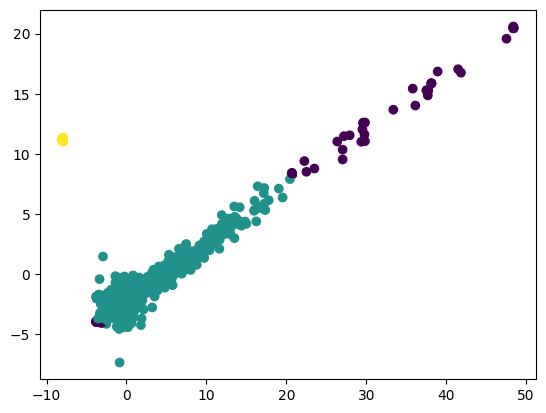

In [85]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=clustering.labels_,
           )

Теперь Гауссовская смесь.

In [871]:
from sklearn.mixture import GaussianMixture

for k in range(2, 10):
    print(k, ':')
    gm = GaussianMixture(n_components=k, random_state=0).fit(principal)
    gm.predict(principal)
    print(metrics.silhouette_score(principal,gm.predict(principal)), metrics.silhouette_score(x,gm.predict(principal)))
    print(metrics.calinski_harabasz_score(principal,gm.predict(principal)), metrics.calinski_harabasz_score(x,gm.predict(principal)))
    print(metrics.davies_bouldin_score(principal,gm.predict(principal)), metrics.davies_bouldin_score(x,gm.predict(principal)))
    
gm = GaussianMixture(n_components=6, random_state=0).fit(principal)

2 :
0.5456485096114431 0.29346636481061916
700.2034146500279 369.10298552622885
1.4010017164544168 2.101823088849856
3 :
0.7586489876637008 0.40466751472161694
2202.5126046495357 817.2175520199947
0.8689964528442752 1.5123015339989545
4 :
0.7478908682385698 0.3558155304795659
1820.3165467863041 602.1354565943459
1.4009636552421536 2.3396531136055874
5 :
0.7606973940697637 0.28619351790627384
5264.616641617222 799.6069740900343
0.8569261171444392 1.8832027355513348
6 :
0.7727920892806244 0.25719050494443724
6956.355791166623 712.1631924924658
0.6230605484726678 1.5149434173980827
7 :
0.7795675830318283 0.15945849341965782
7904.52678961021 606.0628536450798
0.41855082296124063 2.1997077704808348
8 :
0.780865161074503 0.15844751566088489
9325.235235382554 537.8674197593094
0.4181645018559555 2.0908744762199887
9 :
0.78391496687773 0.1596962992753539
11035.476536333112 485.8129747935741
0.4274361036665342 2.04998713659097


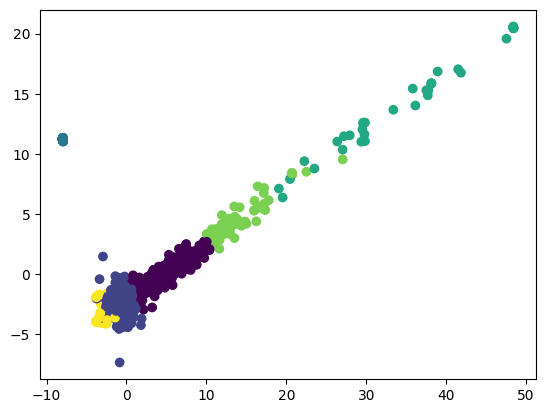

In [872]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=gm.predict(principal),
           )

Путем перебора я получил, что именно при 6 кластерах достигается максимум метрики:

In [928]:
metrics.silhouette_score(principal,l)

0.822973620521182

Самым лучшим по метрике оказался KMeans. При этом график двумерной проекции выглядит наиболее адекватным нашим данным (кластеры выделены разумно).

In [929]:
df['clust'] = l

In [930]:
df.to_csv('resumes_features.csv')

**TDA**

Для лучшей работы интерпретации текстов в рамках текстовой аналитики, будем использовать базовые инструменты топологического анализа данных.

In [88]:
# !pip install gudhi
import gudhi as gd

Составим simplex tree n-грамм:

In [89]:
simplices0 = list(df2['О себе, summarized'])
simplices1 = list(df2['О себе 2'])
simplices2 = list(df2['О себе 3'])

In [90]:
st = gd.SimplexTree()

Заполним его n-граммами:

In [91]:
text_to_num = dict()
num_to_text = dict()
i = 0

for x in simplices0:
    if x is not None:
        for y in x:
            if y not in text_to_num.keys():
                text_to_num[y] = i
                num_to_text[i] = y
                i += 1
            st.insert([text_to_num[y]])
        
for x in simplices1:
    if x is not None:
        for y in x:
            st.insert([text_to_num[y.split(' ')[0]], text_to_num[y.split(' ')[1]]])
        
for x in simplices2:
    if x is not None:
        for y in x:
            if len(y) > 2:
                st.insert([text_to_num[y.split(' ')[0]], 
                       text_to_num[y.split(' ')[1]], 
                       text_to_num[y.split(' ')[2]]])

Тестируем, хорошо ли работает операция `*`:

In [92]:
st.compute_persistence()
st.betti_numbers()
y = simplices0[0][0]
y = text_to_num['sql']
print(y)
print(st.get_star([y])[:15])
print(num_to_text[0], num_to_text[119], num_to_text[536])

536
[([0, 119, 536], 0.0), ([0, 536], 0.0), ([1, 3, 536], 0.0), ([1, 536], 0.0), ([3, 15, 536], 0.0), ([3, 39, 536], 0.0), ([3, 42, 536], 0.0), ([3, 119, 536], 0.0), ([3, 140, 536], 0.0), ([3, 348, 536], 0.0), ([3, 536], 0.0), ([3, 536, 652], 0.0), ([3, 536, 752], 0.0), ([3, 536, 1101], 0.0), ([3, 536, 1556], 0.0)]
уверенный vba sql


In [143]:
st.betti_numbers()

[1, 12184]

In [93]:
y = simplices1[3][1]
print(y)
print(st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15])
print(num_to_text[20], num_to_text[37], num_to_text[38])

время заниматься
[([20, 47, 48], 0.0), ([33, 47, 48], 0.0), ([40, 47, 48], 0.0), ([46, 47, 48], 0.0), ([47, 48], 0.0), ([47, 48, 49], 0.0), ([47, 48, 51], 0.0), ([47, 48, 52], 0.0), ([47, 48, 53], 0.0), ([47, 48, 77], 0.0), ([47, 48, 78], 0.0), ([47, 48, 94], 0.0), ([47, 48, 99], 0.0), ([47, 48, 108], 0.0), ([47, 48, 120], 0.0)]
работа заседание анализ


In [142]:
y = simplices2[3][1]
y = 'ум способность работать'
y = 'работать способность успешно'
y = 'способность задача успешно'
y = 'аналитический способность задача'
y = 'аналитический задача подход'
y = 'проектный задача подход'
y = 'задача подход выполнять'
y = 'ответственный подход выполнять'
y = 'ответственный творческий подход'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

ответственный творческий подход :
ответственный уметь творческий
ответственный обучать творческий
ответственный творческий подход
ответственный творческий информация
ответственный творческий подход :
ответственный обучаемость подход
ответственный творческий подход
ответственный подход выполнять
ответственный подход дело
ответственный творческий подход :
работа творческий подход
презентация творческий подход
ум творческий подход
способность творческий подход
решение творческий подход
ответственный творческий подход
мышление творческий подход
уровень творческий подход
творческий подход выполнение
творческий подход пунктуальность
творческий подход дело


In [116]:
principal.loc[:300, 'principal component 1']

0      -0.169491
1      -0.303798
2       0.188959
3       1.057477
4       1.722029
         ...    
296     0.687806
297    -0.148542
298    47.549595
299    -0.481828
300    -0.771987
Name: principal component 1, Length: 301, dtype: float64

**Анализ кластеров**

Самым лучшим оказался KMeans. Проанализируем наши данные, основываясь на его результатах.

In [19]:
df = pd.read_csv('resumes_features.csv')

In [5]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [6]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
719,https://hh.ru/resume/85ea36bb0002ddc7fd0039ed1...,Аналитик,"Москва, м. Сходненская, не готов к переезду, н...",Опыт работы 5 лет 2 месяца,"Коммуникабельность, активная жизненная позиция...",Высшее образование (Бакалавр)\n2018\nМосковски...,Специализации:\nАналитик\nЗанятость: полная за...,"Работа с компьютерными программами, программы ...",Московский Государственный институт индустрии ...,Колледж малого бизнеса 48,...,0.000453,-0.000027,-0.001687,-0.000568,-0.001011,-0.000525,-0.001164,0,2.0,0.0


Что за кластеры:

In [938]:
df2['О себе 3'] #, df2['О себе, sumarrized']

0       [уверенный пользователь пк, пользователь пк ms...
1       [настоящий время заниматься, время заниматься ...
2       [крупный медучреждение россия, медучреждение р...
3       [настоящий время заниматься, время заниматься ...
4       [настоящий время работать, время работать комп...
                              ...                        
2720    [крупный российский банковский, российский бан...
2721    [находиться поиск работа, поиск работа который...
2722    [una отечественный компания, отечественный ком...
2723                                                 None
2724                                                 None
Name: О себе 3, Length: 2725, dtype: object

In [144]:
df.loc[df['clust']==0]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
4       Дисциплина - умение выполнять поставленные зад...
                              ...                        
2714    Опыт управления более 15-и лет. Развитые управ...
2715    Аналитика продаж ,поиск клиентов,связь с произ...
2719    Многозадачность, стрессоустойчивость, инициати...
2720    Уверенный пользователь ПК: MS Office (Word, Ex...
2722                                                    .
Name: О себе, Length: 2130, dtype: object

In [40]:
df.loc[(df['clust']==0) & (df['DA, predicted']==2)]['О себе'].index
df2.loc[df.loc[(df['clust']==0) & (df['DA, predicted']==2)]['О себе'].index]['О себе 3']

11      [эксперт область аудит, область аудит аудит, а...
35      [российский эксперт область, эксперт область б...
64      [неделя хотеть поделиться, хотеть поделиться о...
76      [данный момент работать, момент работать компа...
88      [настоящий время работать, время работать круп...
                              ...                        
2565    [форвард сборная россия, сборная россия хоккей...
2573    [финансист экономист плановик, экономист плано...
2621    [данный момент являться, момент являться менед...
2640    [данный момент заниматься, момент заниматься т...
2696    [пройти курс управление, курс управление персо...
Name: О себе 3, Length: 95, dtype: object

In [339]:
cluster_ind = df.loc[(df['clust']==0) & (df['DA, predicted']==2)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(25))

[('настоящий время работать', 11), ('время работать крупный', 5), ('иметь опыт работа', 4), ('находиться поиск работа', 4), ('данный момент являться', 3), ('имя м ломоносов', 3), ('требоваться высокопоставленный сотрудник', 3), ('данный момент работать', 2), ('самый известный российский', 2), ('обладать чувство ответственность', 2), ('чувство ответственность высокий', 2), ('ответственность высокий работоспособность', 2), ('высокий работоспособность вариативный', 2), ('работоспособность вариативный мышление', 2), ('вариативный мышление стрессоустойчивый', 2), ('мышление стрессоустойчивый инициативный', 2), ('стрессоустойчивый инициативный нацелить', 2), ('инициативный нацелить результат', 2), ('нацелить результат уметь', 2), ('результат уметь самостоятельно', 2), ('уметь самостоятельно принимать', 2), ('самостоятельно принимать решение', 2), ('работать крупный россия', 2), ('данный момент иметь', 2), ('момент иметь опыт', 2)]


In [343]:
y = 'уметь самостоятельно принимать'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

уметь самостоятельно принимать :
самостоятельно результат уметь
самостоятельно уметь принимать
уметь самостоятельно принимать :
самостоятельно уметь принимать
решение уметь принимать
лидер уметь принимать
результат уметь принимать
уметь принимать горизонт
уметь принимать взвесить
уметь самостоятельно принимать :
умение самостоятельно принимать
самостоятельно решение принимать
самостоятельно уметь принимать
самостоятельно принимать готовность


In [344]:
cluster_ind = df.loc[(df['clust']==0) & (df['DA, predicted']==1)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(30))

[('c software c', 9), ('software c software', 9), ('находиться поиск работа', 9), ('данный момент работать', 6), ('иметь опыт работа', 5), ('гражданин россия проживать', 5), ('уверенный пользователь пк', 5), ('настоящий время работать', 5), ('разработчик программный обеспечение', 4), ('работать больший объём', 4), ('больший объём информация', 4), ('россия проживать санкт', 4), ('проживать санкт петербург', 4), ('крупный российский розничный', 3), ('работа данный момент', 3), ('поиск работа специальность', 3), ('моделирование бизнес процесс', 3), ('настоящий время заниматься', 3), ('находиться возраст год', 3), ('сборная россия хоккей', 2), ('россия хоккей мяч', 2), ('направление анализ данные', 2), ('данный момент иметь', 2), ('момент иметь опыт', 2), ('программный обеспечение компьютерный', 2), ('находиться декретный отпуск', 2), ('качество необходимый успешный', 2), ('работать рекламный агентство', 2), ('поиск работа сфера', 2), ('российский розничный кредитный', 2)]


In [348]:
y = 'разработчик программный обеспечение'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

разработчик программный обеспечение :
специалист разработчик программный
российский разработчик программный
аналитик разработчик программный
обеспечение разработчик программный
программирование разработчик программный
должность разработчик программный
разработчик программный программа
разработчик программный интерфейс
разработчик программный плановик
разработчик программный администратор
разработчик программный копирайтер
разработчик программный провайдер
разработчик программный системоинженер
разработчик программный обеспечение :
система обеспечение разработчик
обеспечение разработчик программный
обеспечение разработчик владелец
разработчик программный обеспечение :
ms обеспечение программный
amocrm обеспечение программный
система обеспечение программный
навык обеспечение программный
анализ обеспечение программный
заниматься обеспечение программный
мир обеспечение программный
крупный обеспечение программный
требоваться обеспечение программный
область обеспечение программный
опыт обесп

In [148]:
cluster_ind = df.loc[(df['clust']==0)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(40))

[('настоящий время работать', 71), ('находиться поиск работа', 68), ('настоящий время заниматься', 59), ('данный момент работать', 52), ('гражданин россия проживать', 47), ('иметь опыт работа', 41), ('уверенный пользователь пк', 39), ('умение работать команда', 39), ('открыться вакантный должность', 34), ('аналитический склад ум', 32), ('опыт работа сфера', 32), ('проживать санкт петербург', 28), ('данный момент заниматься', 27), ('разработка программный обеспечение', 27), ('разработчик программный обеспечение', 26), ('рамка подготовка чемпионат', 24), ('подготовка чемпионат мир', 24), ('опытный пользователь пк', 23), ('время работать крупный', 23), ('данный момент являться', 23), ('россия проживать санкт', 23), ('находиться возраст год', 23), ('данный момент иметь', 22), ('поиск работа сфера', 20), ('institute of technology', 20), ('компания заниматься разработка', 20), ('мир хоккей мяч', 19), ('заниматься информационный технология', 18), ('чемпионат мир хоккей', 18), ('больший объём 

In [171]:
y = 'ведение переговоры иностранный'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

ведение переговоры иностранный :
пк ведение переговоры
деловой ведение переговоры
общение ведение переговоры
клиент ведение переговоры
навык ведение переговоры
заниматься ведение переговоры
продажа ведение переговоры
ведение коммерческий переговоры
ведение переговоры опыт
ведение переговоры умение
ведение переговоры управление
ведение переговоры уровень
ведение переговоры сотрудник
ведение переговоры иностранный
ведение переговоры иностранный :
ведение переговоры иностранный
ведение переговоры иностранный :
клиент переговоры иностранный
ведение переговоры иностранный
переговоры опыт иностранный
переговоры компания иностранный
переговоры готовый иностранный
переговоры иностранный вести
переговоры иностранный инвестор


In [9]:
pca = PCA(n_components=3)
principalComponents1 = pca.fit_transform((df.loc[df['clust']==0, list(df)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]))
principal1 = pd.DataFrame(data = principalComponents1
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Посмотрим, сколько информации сохраняют первые две главные компоненты:

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

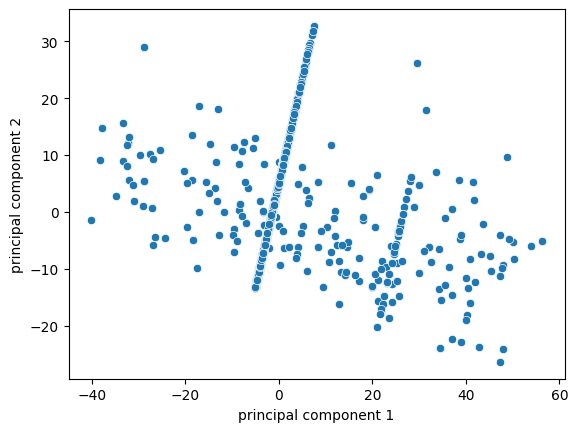

In [10]:
sns.scatterplot(principal1['principal component 1'], principal1['principal component 2'])

In [946]:
df.loc[df['clust']==1]['О себе']

22      ---
31      ---
33      ---
34      ---
46      ---
       ... 
2711    ---
2716    ---
2717    ---
2723    ---
2724    ---
Name: О себе, Length: 356, dtype: object

Рассмотрим теперь 3 кластер:

In [947]:
df.loc[df['clust']==2]['О себе']

58      Общий стаж работы более 20 лет. Легко обучаюсь...
128     Легко и быстро обучаюсь, целеустремленная, вни...
298     Добрый день. Немного обо мне: Успешное провиде...
336     Аналитический склад ума, высокая концентрация,...
376     Пунктуальная, исполнительная, мобильная.\nУмею...
513     • Умею и люблю учиться;\n• Пунктуальна и дисци...
593     Работал с людьми обладаю управлять командой зн...
661     Люблю ответственность и ответственных людей, п...
759     Умею работать в режиме многозадачности, пункту...
891     Ответственная, целеустремленная, коммуникабель...
1020    Готова сразу приступить к работе.\n\nExcel- ув...
1140    Люблю думать, создавать, видеть в своей работе...
1298    Имею опыт работы в коллективе, организована, о...
1442    Здравствуйте, меня зовут Ксения.\nИз качеств о...
1493    Уравновешенный, целеустремленный, коммуникабел...
1530    Я люблю интересную работу с возможностями разв...
1556    Очень люблю автомобили, много читаю, в т.ч. те...
1595    Легко 

In [172]:
cluster_ind = df.loc[(df['clust']==2)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(40))

[('данный момент работать', 37), ('находиться поиск работа', 34), ('поиск работа данный', 34), ('работа данный момент', 34), ('момент работать московский', 12), ('работать московский офис', 12), ('момент работать крупный', 9), ('момент работать сфера', 7), ('работать крупный россия', 6), ('работать сфера маркетинг', 4), ('сфера маркетинг реклама', 4), ('момент работать самый', 4), ('крупный россия банковский', 4), ('россия банковский холдинг', 4), ('маркетинг реклама продажа', 3), ('момент работать компания', 3), ('работать компания который', 2), ('работать самый интересный', 2), ('работать самый престижный', 2), ('работать крупный российский', 2), ('крупный россия компания', 2), ('работать сфера торговля', 1), ('работать сфера продажа', 1), ('компания который заниматься', 1), ('который заниматься производство', 1), ('заниматься производство бережливый', 1), ('производство бережливый продукция', 1), ('самый интересный амбициозный', 1), ('интересный амбициозный проект', 1), ('амбициозны

In [188]:
y = 'продажа работать возражение'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

продажа работать возражение :
навык продажа работать
продажа сфера работать
продажа работать возражение
продажа работать команда
продажа работать центр
продажа работать отдел
продажа работать менеджер
продажа работать нравиться
продажа работать любить
продажа работать возражение :
продажа работать возражение
продажа работать возражение :
клиент работать возражение
продажа работать возражение
работать возражение организаторский


In [328]:
print(df.loc[df['clust']==3]['О себе'].sample(1).iloc[0])

Хорошо работаю в команде, умею решать конфликты и идти на компромисс. С энтузиазмом берусь за новые проекты и довожу дело до конца. Обладаю аналитическим складом ума, быстро генерирую необычные идеи для решения задач пользуясь творческим подходом к делу.


In [189]:
cluster_ind = df.loc[(df['clust']==3)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(40))

[('данный момент работать', 112), ('находиться поиск работа', 86), ('работа данный момент', 38), ('поиск работа данный', 34), ('момент работать крупный', 32), ('момент работать сфера', 26), ('поиск работа хотеть', 17), ('работать крупный россия', 16), ('работать сфера маркетинг', 13), ('сфера маркетинг реклама', 13), ('момент работать самый', 13), ('работа хотеть заполучить', 12), ('маркетинг реклама продажа', 12), ('момент работать компания', 11), ('поиск работа сфера', 11), ('момент работать московский', 10), ('работать московский офис', 9), ('работать компания который', 8), ('хотеть заполучить должность', 8), ('крупный россия компания', 8), ('россия компания заниматься', 7), ('работать самый известный', 7), ('данный момент заниматься', 6), ('заполучить должность директор', 5), ('компания который заниматься', 5), ('работать сфера продажа', 5), ('момент работать офис', 5), ('заниматься информационный технология', 5), ('крупный it компания', 4), ('московский офис находиться', 4), ('офи

In [188]:
y = 'продажа работать возражение'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

продажа работать возражение :
навык продажа работать
продажа сфера работать
продажа работать возражение
продажа работать команда
продажа работать центр
продажа работать отдел
продажа работать менеджер
продажа работать нравиться
продажа работать любить
продажа работать возражение :
продажа работать возражение
продажа работать возражение :
клиент работать возражение
продажа работать возражение
работать возражение организаторский


In [334]:
print(df.loc[df['clust']==4]['О себе'].iloc[1])

Интиллегентный, ответственный, целеустремлённый.
Аналитик по натуре.
Готов к командировкам, самоорганизован.


In [190]:
cluster_ind = df.loc[(df['clust']==4)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(40))

[('президент россия владимир', 39), ('россия владимир путин', 39), ('встреча президент россия', 28), ('владимир путин пройти', 23), ('путин пройти накануне', 15), ('f f f', 15), ('санкт петербург встреча', 14), ('присутствие президент рф', 14), ('президент рф владимир', 14), ('рф владимир путин', 14), ('пройти накануне санкт', 13), ('накануне санкт петербург', 13), ('владимир путин премьер', 13), ('путин премьер министр', 13), ('встреча пройти присутствие', 12), ('пройти присутствие президент', 12), ('премьер министр владимир', 11), ('министр владимир путин', 11), ('петербург встреча пройти', 9), ('путин пройти четверг', 7), ('гражданин россия проживать', 7), ('россия проживать санкт', 7), ('проживать санкт петербург', 7), ('санкт петербург готовиться', 7), ('петербург готовиться переезд', 7), ('пройти четверг москва', 5), ('владимир путин состояться', 5), ('путин состояться накануне', 5), ('петербург встреча проходить', 5), ('встреча проходить присутствие', 5), ('проходить присутствие

In [188]:
y = 'продажа работать возражение'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

продажа работать возражение :
навык продажа работать
продажа сфера работать
продажа работать возражение
продажа работать команда
продажа работать центр
продажа работать отдел
продажа работать менеджер
продажа работать нравиться
продажа работать любить
продажа работать возражение :
продажа работать возражение
продажа работать возражение :
клиент работать возражение
продажа работать возражение
работать возражение организаторский


In [95]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 2130
2 : 356
3 : 37
4 : 162
5 : 40


In [962]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x, ['DA, predicted']].value_counts())

1 : DA, predicted
0.0              1837
1.0               198
2.0                95
dtype: int64
2 : DA, predicted
0.0              337
1.0               15
2.0                4
dtype: int64
3 : DA, predicted
1.0              22
0.0              15
dtype: int64
4 : DA, predicted
0.0              131
1.0               29
2.0                2
dtype: int64
5 : DA, predicted
0.0              36
1.0               4
dtype: int64


In [21]:
from nltk import FreqDist

In [944]:
for x in np.unique(df['clust']):
    cluster_ind = df.loc[df['clust']==x]['О себе'].index
    cluster_tokens = []

    for i in cluster_ind:
        if df2.loc[i, 'О себе 3'] != None:
            cluster_tokens += df2.loc[i, 'О себе 3']

    print(x, ':', FreqDist(cluster_tokens).most_common(15))

0 : [('настоящий время работать', 71), ('находиться поиск работа', 68), ('настоящий время заниматься', 59), ('данный момент работать', 52), ('гражданин россия проживать', 47), ('иметь опыт работа', 41), ('уверенный пользователь пк', 39), ('умение работать команда', 39), ('открыться вакантный должность', 34), ('аналитический склад ум', 32), ('опыт работа сфера', 32), ('проживать санкт петербург', 28), ('данный момент заниматься', 27), ('разработка программный обеспечение', 27), ('разработчик программный обеспечение', 26)]
1 : []
2 : [('данный момент работать', 37), ('находиться поиск работа', 34), ('поиск работа данный', 34), ('работа данный момент', 34), ('момент работать московский', 12), ('работать московский офис', 12), ('момент работать крупный', 9), ('момент работать сфера', 7), ('работать крупный россия', 6), ('работать сфера маркетинг', 4), ('сфера маркетинг реклама', 4), ('момент работать самый', 4), ('крупный россия банковский', 4), ('россия банковский холдинг', 4), ('маркетин

In [ ]:
y = 'f f f'

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[1]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])
        
print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[0]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

print(y, ':')
search_results = st.get_star([text_to_num[y.split(' ')[1]], 
                    text_to_num[y.split(' ')[2]]])[:15]
for x in search_results:
    if len(x[0]) == 3:
        print(num_to_text[x[0][0]], num_to_text[x[0][1]], num_to_text[x[0][2]])

f f f :

In [953]:
for x in np.unique(df['clust']):
    print(x, ':\n', df.loc[df['clust']==x]['DA, predicted'].value_counts())

0 :
 0.0    1837
1.0     198
2.0      95
Name: DA, predicted, dtype: int64
1 :
 0.0    337
1.0     15
2.0      4
Name: DA, predicted, dtype: int64
2 :
 1.0    22
0.0    15
Name: DA, predicted, dtype: int64
3 :
 0.0    131
1.0     29
2.0      2
Name: DA, predicted, dtype: int64
4 :
 0.0    36
1.0     4
Name: DA, predicted, dtype: int64


Дополнительная информация о кластерах:

In [357]:
for col in ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']:
    print(df.loc[(df['clust']==0) & (df['DA, predicted']==1)][col].value_counts())
    print(df.loc[(df['clust']==0) & (df['DA, predicted']==1)][col].describe())

1    110
2     68
3     16
4      2
0      1
7      1
Name: Кол-во образований, dtype: int64
count    198.000000
mean       1.560606
std        0.795842
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: Кол-во образований, dtype: float64
-1.000000     5
 9.250000     3
 11.250000    3
 3.333333     3
 2.500000     3
             ..
 11.583333    1
 8.250000     1
 10.250000    1
 25.083333    1
 15.833333    1
Name: Опыт нормализованный, Length: 136, dtype: int64
count    198.000000
mean       9.264731
std        7.305132
min       -1.000000
25%        3.416667
50%        7.375000
75%       13.104167
max       42.416667
Name: Опыт нормализованный, dtype: float64
0    171
1     27
Name: Топовость образования, dtype: int64
count    198.000000
mean       0.136364
std        0.344044
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Топовость образования, dtype: float64
1    111


In [358]:
for col in ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']:
    print(df.loc[(df['clust']==0) & (df['DA, predicted']==2)][col].value_counts())
    print(df.loc[(df['clust']==0) & (df['DA, predicted']==2)][col].describe())

1    46
2    33
3    12
4     2
0     1
5     1
Name: Кол-во образований, dtype: int64
count    95.000000
mean      1.694737
std       0.863857
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       5.000000
Name: Кол-во образований, dtype: float64
-1.000000     4
 6.333333     3
 1.333333     3
 2.333333     2
 3.333333     2
             ..
 2.666667     1
 5.250000     1
 22.500000    1
 23.583333    1
 4.833333     1
Name: Опыт нормализованный, Length: 73, dtype: int64
count    95.000000
mean      7.929825
std       7.742698
min      -1.000000
25%       2.333333
50%       5.333333
75%      12.625000
max      31.916667
Name: Опыт нормализованный, dtype: float64
0    83
1    12
Name: Топовость образования, dtype: int64
count    95.000000
mean      0.126316
std       0.333967
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Топовость образования, dtype: float64
1    56
0    39
Name: Справочник по интере

**Формализация качества решения**

Формализуем, что такое хорошее решение задачи. Кластеризация: silhouette score, классификация: $F_1$, сегментация: средний word2vec среди 15 наиболеее поаулярных слов в кластере. 

Обучим отдельный word2vec на словах `df2['О себе, summarized']`, чтобы сравнить:

In [191]:
word2vec_2 = 0

In [192]:
df_formalize = df.copy()

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [193]:
df2.loc[df2['О себе, summarized'].isna(), 'О себе, summarized'] = '-'

In [194]:
df2[df2['О себе, summarized'].isna()]['О себе, summarized']

Series([], Name: О себе, summarized, dtype: object)

Обучим модель:

In [196]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [197]:
model2 = Word2Vec(sentences=df2['О себе, summarized'], vector_size=100, window=5, min_count=1, workers=4)
# model.save("word2vec.model")

In [198]:
model2.train(df2['О себе, summarized'], total_examples=len(df2['О себе, summarized']), epochs=1)

(42214, 46918)

Посмотрим, что получилось, на примере:

In [201]:
vector = model2.wv['подход']  # get numpy vector of a word
sims = model2.wv.most_similar('подход', topn=10)  # get other similar words

In [202]:
vector

array([-0.19693287,  0.23970526,  0.00191992,  0.0268054 ,  0.11340711,
       -0.44597515,  0.13188286,  0.6573758 , -0.13976535, -0.07357504,
       -0.15376855, -0.32503912, -0.13306424,  0.21024442,  0.09590898,
       -0.19631457,  0.09530957, -0.23938283, -0.01206137, -0.4596275 ,
        0.09497388,  0.1627233 ,  0.00154596, -0.25499317, -0.01978723,
        0.01198395, -0.12584282, -0.12976594, -0.23025885, -0.03504842,
        0.2823933 , -0.05442722,  0.11444207, -0.09662499, -0.21420127,
        0.29625675,  0.07440826, -0.37658733, -0.1310264 , -0.46504563,
       -0.08621243, -0.25888065, -0.0163994 , -0.042024  ,  0.2538652 ,
        0.06709417, -0.22566976, -0.11254929,  0.0467411 ,  0.165953  ,
        0.07697635, -0.1485228 , -0.18773845,  0.0316276 , -0.17030115,
        0.18307208,  0.11689176, -0.09968792, -0.28781387,  0.04503743,
        0.06582955,  0.13445692,  0.00651411, -0.01636244, -0.32768303,
        0.29192775,  0.03742402,  0.07623387, -0.3116488 ,  0.44

In [203]:
sims

[('решение', 0.9993782043457031),
 ('быстро', 0.9992536306381226),
 ('задача', 0.9991648197174072),
 ('переговоры', 0.9991605877876282),
 ('профессиональный', 0.9990921020507812),
 ('моделирование', 0.9990764260292053),
 ('эффективный', 0.9990240931510925),
 ('план', 0.9990000128746033),
 ('•', 0.9989727735519409),
 ('составление', 0.9989621043205261)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из среднего координат входящих в раздел "О себе" триграмм.

In [204]:
our_data2 = pd.DataFrame(df2['О себе, summarized'])
our_data2['emb'] = 0
embs = []
for x in our_data2['О себе, summarized']:
    cur_embs = []
    for y in x:
        cur_embs.append(model2.wv[y])
    embs.append(cur_embs)
our_data2['emb'] = embs

embs_flattened = []
for x in our_data2['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data2['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [206]:
our_data2['flat_emb'][0]

array([-0.22204722,  0.27422416, -0.01886588,  0.01507901,  0.11897265,
       -0.55089194,  0.15420581,  0.7819085 , -0.14974162, -0.16006833,
       -0.14377561, -0.39234704, -0.18844458,  0.2433441 ,  0.1194774 ,
       -0.23299846,  0.07301585, -0.28197914,  0.00079411, -0.5701564 ,
        0.07008892,  0.2130409 ,  0.04485572, -0.34513903, -0.01892565,
       -0.03938448, -0.13201377, -0.15065545, -0.27933112, -0.02923884,
        0.33381674, -0.07913691,  0.14145729, -0.12044895, -0.26744732,
        0.3154427 ,  0.04029484, -0.49790308, -0.15723972, -0.5510567 ,
       -0.09833698, -0.3213486 , -0.04051634, -0.06166724,  0.3134287 ,
        0.07600106, -0.26040444, -0.12326333,  0.05535094,  0.22665617,
        0.09534897, -0.18003328, -0.22219923,  0.04644439, -0.19273645,
        0.22228241,  0.1825238 , -0.10380503, -0.33755198,  0.07871128,
        0.07883327,  0.17562689,  0.00284466, -0.03118394, -0.4072135 ,
        0.35206234,  0.03782948,  0.12349809, -0.3949067 ,  0.48

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее $i$-х координат эмбеддингов входящих в текст эмбеддингов.

Уберем пропуски и запишем в `X` наши векторы:

In [207]:
our_data2['flat_emb'].dropna()
X2 = list(our_data2['flat_emb'].dropna())
X2 = np.asarray(X2)
X2

array([[-0.22204722,  0.27422416, -0.01886588, ..., -0.28522816,
         0.20570731,  0.07442545],
       [-0.20841801,  0.2507909 ,  0.01454645, ..., -0.23935916,
         0.13158953,  0.07569362],
       [-0.28812125,  0.37561652,  0.00760662, ..., -0.3490448 ,
         0.22233666,  0.11124529],
       ...,
       [-0.14205875,  0.18455657,  0.00635898, ..., -0.17212293,
         0.11395276,  0.05590791],
       [ 0.00816812, -0.00444303,  0.00898543, ..., -0.00453567,
         0.00406171, -0.00427018],
       [ 0.00816812, -0.00444303,  0.00898543, ..., -0.00453567,
         0.00406171, -0.00427018]], dtype=float32)

In [214]:
df_formalize.loc[:, list(df_formalize)[37:-3]] = X2

In [215]:
scaler = StandardScaler()
x = scaler.fit_transform(df_formalize.loc[:, list(df_formalize)[37:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [216]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

Посмотрим, сколько информации сохраняют первые две главные компоненты:

In [217]:
pca.explained_variance_ratio_[:2].sum()

0.800704966302124

In [218]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
833,-6.183111,0.938762,0.000404
1967,-4.042190,1.805496,-0.765167


/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

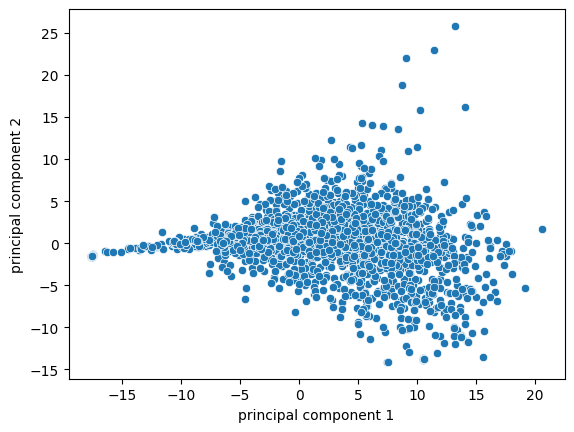

In [219]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

Теперь обучаем PCA+KMeans

Применим elbow method:

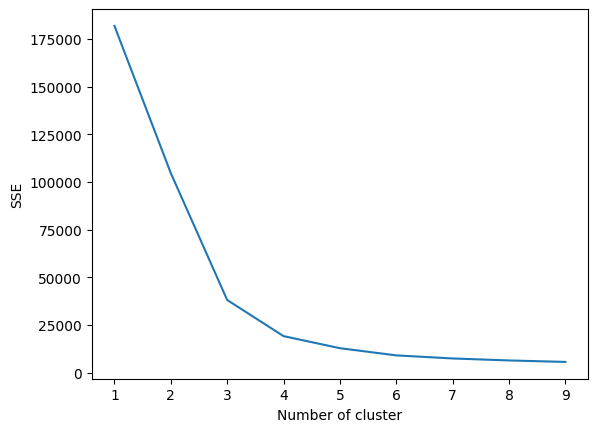

In [855]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = principal

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Выберем число кластеров 8 (по графику elbow method такое число уже неприемлемо, при этом при нем метрика лучше).

In [220]:
from sklearn import metrics

In [222]:
for k in range(2, 10):
    print(k, ':')
    kmeans = KMeans(n_clusters=k).fit(principal)
    l = kmeans.labels_
    print(metrics.silhouette_score(principal,l), metrics.silhouette_score(x,l))
    print(metrics.calinski_harabasz_score(principal,l), metrics.calinski_harabasz_score(x,l))
    print(metrics.davies_bouldin_score(principal,l), metrics.davies_bouldin_score(x,l))

2 :
0.5530588842851664 0.46839435731044166
3265.069633904119 2451.1573606915927
0.5856872024088301 0.7167369110520388
3 :
0.44652284591644925 0.33250901075911216
3329.3171758300946 2192.502933672829
0.8127298324737527 1.1021427103529517
4 :
0.4130102386175595 0.2839562830049225
3145.429641710783 1886.936156433963
0.8764419467298601 1.2392413008484833
5 :
0.4331219422523996 0.2958412287576588
3337.9524180674284 1780.313513074827
0.7425875883078127 1.0721328677389892
6 :
0.40868641107658105 0.25924118803136786
3322.147269908081 1621.7456256723162
0.7940553686841332 1.2374297210487004
7 :
0.41326739762194925 0.2612165339394844
3344.4193893224133 1521.8202151891364
0.8064476081735678 1.2454242778521858
8 :
0.40339468143394447 0.23580888747623124
3351.6097915704195 1408.4892372702564
0.8086726447660245 1.3342149303297364
9 :
0.40538902293286494 0.23147268923505682
3330.439871207539 1334.092651592171
0.7922372482377267 1.3205030715535326


In [223]:
kmeans = KMeans(n_clusters=2).fit(principal)
l = kmeans.labels_

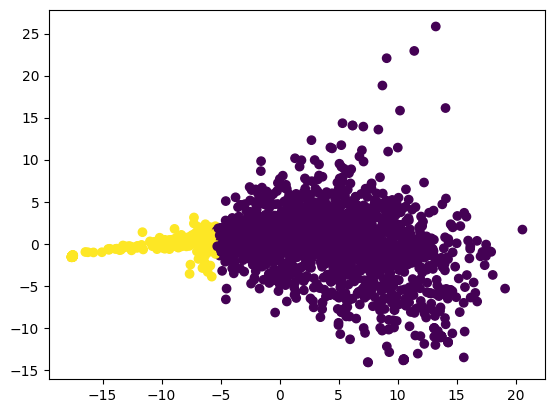

In [224]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

Качество существенно хуже!

In [228]:
df_formalize['clust'] = l

Не будем смотреть, поскольку кластер плохой:

In [239]:
cluster_ind = df_formalize.loc[(df_formalize['clust']==1)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе, summarized'] != None:
        cluster_tokens += df2.loc[i, 'О себе, summarized']

print(FreqDist(cluster_tokens).most_common(10))

[('-', 356), ('and', 36), ('of', 20), ('врач', 19), ('in', 18), ('российский', 16), ('россия', 15), ('год', 14), ('to', 14), ('хобби', 14)]


Сравним хорошие кластеры:

In [275]:
cluster_ind = df_formalize.loc[(df_formalize['clust']==0)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе, summarized'] != None:
        cluster_tokens += df2.loc[i, 'О себе, summarized']

print(FreqDist(cluster_tokens).most_common(10))

[('работа', 998), ('работать', 564), ('опыт', 517), ('компания', 479), ('заниматься', 427), ('находиться', 377), ('российский', 353), ('крупный', 346), ('россия', 338), ('данный', 328)]


In [279]:
sims = []
for x in FreqDist(cluster_tokens).most_common(10):
    for y in FreqDist(cluster_tokens).most_common(10):
        if x != y:
            # print(x, y)
            sims.append(model2.wv.similarity(x[0], y[0]))
np.mean(sims)

0.9755427

In [272]:
cluster_ind = df.loc[(df['clust']==0)]['О себе'].index
cluster_tokens = []

for i in cluster_ind:
    if df2.loc[i, 'О себе 3'] != None:
        cluster_tokens += df2.loc[i, 'О себе 3']

print(FreqDist(cluster_tokens).most_common(10))

[('настоящий время работать', 71), ('находиться поиск работа', 68), ('настоящий время заниматься', 59), ('данный момент работать', 52), ('гражданин россия проживать', 47), ('иметь опыт работа', 41), ('уверенный пользователь пк', 39), ('умение работать команда', 39), ('открыться вакантный должность', 34), ('аналитический склад ум', 32)]


In [273]:
sims = []
for x in FreqDist(cluster_tokens).most_common(10):
    for y in FreqDist(cluster_tokens).most_common(10):
        if x != y:
            sims.append(model.wv.similarity(x[0], y[0]))
np.mean(sims)

0.01775296

Мы видим значительное снижение!

Проверим теперь DT:

In [301]:
def validate2(alg, semi_supervised=False, not_sklearn=False):
    f1_weighted_array = []
    f1_macro_array = []
    f1_micro_array = []
    good_predictions_array = []
    value_counts_df = pd.DataFrame()
    for k in range(28):
        if semi_supervised:
            X = df_formalize.loc[df_formalize['DA'] != -1].loc[:, list(df_formalize)[37:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df_formalize.loc[df_formalize['DA'] != -1, 'DA']
            
            X_2 = df_formalize.loc[:, list(df_formalize)[37:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y_2 = df_formalize.loc[:, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            X_train = X_2.drop(X_test.index)
            y_train = y_2.drop(y_test.index)

            X_2.drop(X_test.index, inplace=True)
            y_2.drop(y_test.index, inplace=True)
            
            if not_sklearn:
                X = np.array(X)
                y = np.array(y).astype('int32')
                X_2 = np.array(X_2)
                y_2 = np.array(y_2).astype('int32')
                X_test = np.array(X_test)
                y_test = np.array(y_test).astype('int32')

            alg.fit(X_2, y_2)
            # print(np.unique(y_2))
        else:
            X = df_formalize.loc[df_formalize['DA'] != -1].loc[:, list(df_formalize)[36:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df_formalize.loc[df_formalize['DA'] != -1, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            alg.fit(X_train, y_train)
        
        f1_weighted = f1_score(y_test, alg.predict(X_test), average='weighted')
        f1_weighted_array.append(f1_weighted)
        f1_macro = f1_score(y_test, alg.predict(X_test), average='macro')
        f1_macro_array.append(f1_macro)
        f1_micro = f1_score(y_test, alg.predict(X_test), average='micro')
        f1_micro_array.append(f1_micro)
        
        tf = pd.DataFrame(np.array(alg.predict(X_test))==np.array(y_test)).value_counts()
        good_predictions = tf[True] / (tf[True]+tf[False])
        good_predictions_array.append(good_predictions)
        
        if k != 0:
            value_counts_df += pd.DataFrame(alg.predict(X_test)).value_counts()
        else:
            value_counts_df = pd.DataFrame(alg.predict(X_test)).value_counts()
            
    value_counts_df = value_counts_df / 28
    np.min(good_predictions_array), np.max(good_predictions_array)
    return (str(value_counts_df).strip('\ndtype: float64'), 
            np.min(good_predictions_array), 
            np.mean(good_predictions_array),
            np.max(good_predictions_array),
            
            np.min(f1_micro_array), 
            np.mean(f1_micro_array),
            np.max(f1_micro_array),
            
            np.min(f1_macro_array), 
            np.mean(f1_macro_array),
            np.max(f1_macro_array),
            
            np.min(f1_weighted_array), 
            np.mean(f1_weighted_array),
            np.max(f1_weighted_array)
            )

In [314]:
acc = 0.
k = 20
clf = DecisionTreeClassifier()
#clf = LogisticRegression()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

dt = validate2(clf)

In [315]:
dt

('0.0    157.000000\n2.0      8.178571\n1.0     17.821429',
 0.7650273224043715,
 0.8017174082747853,
 0.8524590163934426,
 0.7650273224043715,
 0.8017174082747853,
 0.8524590163934426,
 0.3142786895322392,
 0.3776576159161585,
 0.4671509971509972,
 0.7443270285792077,
 0.811859588744883,
 0.8503755079164915)

Мы видим, что 1-граммы и 3-граммы одинаково хорошо справляются. А без них? Примерно так же.

In [316]:
def validate2(alg, semi_supervised=False, not_sklearn=False):
    f1_weighted_array = []
    f1_macro_array = []
    f1_micro_array = []
    good_predictions_array = []
    value_counts_df = pd.DataFrame()
    for k in range(28):
        if semi_supervised:
            X = df_formalize.loc[df_formalize['DA'] != -1].loc[:, list(df_formalize)[37:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df_formalize.loc[df_formalize['DA'] != -1, 'DA']
            
            X_2 = df_formalize.loc[:, list(df_formalize)[37:-3] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y_2 = df_formalize.loc[:, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            X_train = X_2.drop(X_test.index)
            y_train = y_2.drop(y_test.index)

            X_2.drop(X_test.index, inplace=True)
            y_2.drop(y_test.index, inplace=True)
            
            if not_sklearn:
                X = np.array(X)
                y = np.array(y).astype('int32')
                X_2 = np.array(X_2)
                y_2 = np.array(y_2).astype('int32')
                X_test = np.array(X_test)
                y_test = np.array(y_test).astype('int32')

            alg.fit(X_2, y_2)
            # print(np.unique(y_2))
        else:
            X = df_formalize.loc[df_formalize['DA'] != -1].loc[:, ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
            y = df_formalize.loc[df_formalize['DA'] != -1, 'DA']

            X_train = X.sample(200)
            y_train = y[X_train.index]

            X_test = X.drop(X_train.index)
            y_test = y.drop(y_train.index)

            alg.fit(X_train, y_train)
        
        f1_weighted = f1_score(y_test, alg.predict(X_test), average='weighted')
        f1_weighted_array.append(f1_weighted)
        f1_macro = f1_score(y_test, alg.predict(X_test), average='macro')
        f1_macro_array.append(f1_macro)
        f1_micro = f1_score(y_test, alg.predict(X_test), average='micro')
        f1_micro_array.append(f1_micro)
        
        tf = pd.DataFrame(np.array(alg.predict(X_test))==np.array(y_test)).value_counts()
        good_predictions = tf[True] / (tf[True]+tf[False])
        good_predictions_array.append(good_predictions)
        
        if k != 0:
            value_counts_df += pd.DataFrame(alg.predict(X_test)).value_counts()
        else:
            value_counts_df = pd.DataFrame(alg.predict(X_test)).value_counts()
            
    value_counts_df = value_counts_df / 28
    np.min(good_predictions_array), np.max(good_predictions_array)
    return (str(value_counts_df).strip('\ndtype: float64'), 
            np.min(good_predictions_array), 
            np.mean(good_predictions_array),
            np.max(good_predictions_array),
            
            np.min(f1_micro_array), 
            np.mean(f1_micro_array),
            np.max(f1_micro_array),
            
            np.min(f1_macro_array), 
            np.mean(f1_macro_array),
            np.max(f1_macro_array),
            
            np.min(f1_weighted_array), 
            np.mean(f1_weighted_array),
            np.max(f1_weighted_array)
            )

In [317]:
acc = 0.
k = 20
clf = DecisionTreeClassifier()
#clf = LogisticRegression()
self_training_model = GridSearchCV(
            SelfTrainingClassifier(clf), parameters, scoring=f1_score, n_jobs= -1, cv = 3
        )

dt = validate2(clf)

In [318]:
dt

('0.0    160.714286\n1.0     15.035714\n2.0      7.250000',
 0.7595628415300546,
 0.8175253708040593,
 0.8743169398907104,
 0.7595628415300547,
 0.8175253708040593,
 0.8743169398907104,
 0.31290250943815234,
 0.3852934346314704,
 0.4781903919834954,
 0.7731865176763557,
 0.8191739473461032,
 0.873203804897794)

In [319]:
acc = 0.
k = 25
svc = DecisionTreeClassifier()
self_training_model = SelfTrainingClassifier(svc)
    
dt_semi = validate(self_training_model, True)

Мы снова видим небольшое улучшение распределения / macro-$F_1$ с сохранением прочих метрик, как и до этого:

In [320]:
dt_semi

('0.0    154.785714\n1.0     20.392857\n2.0      7.821429',
 0.7049180327868853,
 0.7950819672131147,
 0.8579234972677595,
 0.7049180327868853,
 0.7950819672131147,
 0.8579234972677595,
 0.30888850634073567,
 0.3875952373272825,
 0.48440104786854016,
 0.7520820934552472,
 0.8105509635919935,
 0.8522664126379297)